In [ ]:
! pip install -U langchain openai chromadb langchain-experimental # 최신 버전이 필요합니다 (멀티 모달을 위해)

In [ ]:
! pip install "unstructured[all-docs]" pillow pydantic lxml pillow matplotlib chromadb tiktoken

In [ ]:
!sudo apt-get install poppler-utils
!sudo apt install tesseract-ocr
!sudo apt install libtesseract-dev

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. data path

In [ ]:
from glob import glob

project_path = '/content/drive/MyDrive/Data/dacon/finance'

data_path = project_path + '/open/train_source'
image_path  = project_path + '/processed/image'

data_file_list = glob(data_path + "/*")

In [ ]:
data_file_list

['/content/drive/MyDrive/Data/dacon/finance/open/train_source/2024년도 성과계획서(총괄편).pdf',
 '/content/drive/MyDrive/Data/dacon/finance/open/train_source/중소벤처기업부_창업사업화지원.pdf',
 '/content/drive/MyDrive/Data/dacon/finance/open/train_source/국토교통부_전세임대(융자).pdf',
 '/content/drive/MyDrive/Data/dacon/finance/open/train_source/고용노동부_내일배움카드(일반).pdf',
 '/content/drive/MyDrive/Data/dacon/finance/open/train_source/재정통계해설.pdf',
 '/content/drive/MyDrive/Data/dacon/finance/open/train_source/「FIS 이슈 & 포커스」 23-3호 《조세지출 연계관리》.pdf',
 '/content/drive/MyDrive/Data/dacon/finance/open/train_source/국토교통부_민간임대(융자).pdf',
 '/content/drive/MyDrive/Data/dacon/finance/open/train_source/국토교통부_소규모주택정비사업.pdf',
 '/content/drive/MyDrive/Data/dacon/finance/open/train_source/월간 나라재정 2023년 12월호.pdf',
 '/content/drive/MyDrive/Data/dacon/finance/open/train_source/2024 나라살림 예산ᄀ

# 2. table extract

## 2.1 unstructured (X) 한글은 매우 깨짐

In [ ]:
!pip install markdownify

In [ ]:
!pip show unstructured

Name: unstructured
Version: 0.15.5
Summary: A library that prepares raw documents for downstream ML tasks.
Home-page: https://github.com/Unstructured-IO/unstructured
Author: Unstructured Technologies
Author-email: devops@unstructuredai.io
License: Apache-2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: backoff, beautifulsoup4, chardet, dataclasses-json, emoji, filetype, langdetect, lxml, nltk, numpy, psutil, python-iso639, python-magic, rapidfuzz, requests, tabulate, tqdm, typing-extensions, unstructured-client, wrapt
Required-by: 


In [ ]:
!sudo apt-get install tesseract-ocr-kor

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-kor tesseract-ocr-osd
0 upgraded, 4 newly installed, 0 to remove and 45 not upgraded.
Need to get 5,868 kB of archives.
After this operation, 17.3 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-kor all 1:4.00~git30-7274cfa-1.1 [1,052 kB]
Fetched 5,868 kB in 0s (35.1 MB/s)
debconf: unable to in

In [ ]:
import pytesseract
import cv2
import matplotlib.pyplot as plt

text = pytesseract.image_to_string('/content/스크린샷 2024-08-02 231553.png', lang='kor+eng')
print(text)

김윤웅

Kim Yunwoong

0123456789#$



In [ ]:
!pwd

/content


In [ ]:
import os
# from langchain_text_splitters import CharacterTextSplitter
from unstructured.partition.pdf import partition_pdf

# PDF에서 요소 추출
def extract_pdf_elements(file_path, image_path, **kwards):
    """
    PDF 파일에서 이미지, 테이블, 그리고 텍스트 조각을 추출합니다.
    path: 이미지(.jpg)를 저장할 파일 경로
    fname: 파일 이름
    """
    return partition_pdf(
        filename=file_path,
        strategy="hi_res",
        extract_images_in_pdf=True,         # PDF 내 이미지 추출 활성화
        infer_table_structure=True,         # 테이블 구조 추론 활성화
        languages=["kor", "eng"],                     # 언어
        # chunking_strategy="by_title",     # 제목별로 텍스트 조각화
        # max_characters=4000,              # 최대 문자 수
        # new_after_n_chars=3800,           # 이 문자 수 이후에 새로운 조각 생성
        # combine_text_under_n_chars=2000,  # 이 문자 수 이하의 텍스트는 결합
        # image_output_dir_path=image_path,       # 이미지 출력 디렉토리 경로
        extract_image_block_types=["Image", "Table"],
        extract_image_block_to_payload=False,
        extract_image_block_output_dir=image_path,
        **kwards
    )


def extract_pdf_tabel(file_path):
    return partition_pdf(
        filename=file_path,                  # mandatory
        strategy="hi_res",                                     # mandatory to use ``hi_res`` strategy
        extract_images_in_pdf=True,                            # mandatory to set as ``True``
        extract_image_block_types=["Table"],          # optional
        languages=["kor", "eng"],
    )


# 요소를 유형별로 분류


def categorize_elements(raw_pdf_elements):
    """
    PDF에서 추출된 요소를 테이블과 텍스트로 분류합니다.
    raw_pdf_elements: unstructured.documents.elements의 리스트
    """
    tables = []  # 테이블 저장 리스트
    texts = []  # 텍스트 저장 리스트
    for element in raw_pdf_elements:
        if "unstructured.documents.elements.Table" in str(type(element)):
            tables.append(str(element))  # 테이블 요소 추가
        elif "unstructured.documents.elements.CompositeElement" in str(type(element)):
            texts.append(str(element))  # 텍스트 요소 추가
    return texts, tables

In [ ]:
# 요소 추출
raw_pdf_elements = extract_pdf_elements("/content/재정통계일부.pdf", "/content/images")

config.json:   0%|          | 0.00/1.47k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/115M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/table-transformer-structure-recognition were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
raw_pdf_elements

In [ ]:
tables = [el for el in raw_pdf_elements if el.category == "Table"]
Titles  = [el for el in raw_pdf_elements if el.category == "Title"]
Texts   = [el for el in raw_pdf_elements if el.category == "Text"]
ListItems  = [el for el in raw_pdf_elements if el.category == "ListItem"]
NarrativeTexts  = [el for el in raw_pdf_elements if el.category == "NarrativeText"]

In [ ]:
for ele in raw_pdf_elements:
    print(ele.category)
    print(ele.text)
    print("\n----------\n\n")

Title
12 추 가 경정 추 예 AL ° 2

----------


ListItem
『 2008 년 이후 16 회 의 추 가 경 정 예 산 이 편성

----------


UncategorizedText
2022

----------


Title
된 정

----------


Title
햄 으로

----------


ListItem
480 년 편 성 추 가 징 안은 대부분 초 그 써 입 , 국 차 빌 등 자원 조달

----------


ListItem
ㆍ 2009 년 , 2013 년 , 2015 년 은 주로 국 채 발행, 기 금 여 유 자 금 을 통해 조 달 했고, 2016 년 과 2017 년 은 초 과 세입, 2018 년 은 세 계 잉여금, 2019 년 은 국 채 발 행 과 기 금 여 유 자금, 2021 년 은 국 채 발 행 을 주된 재 원 으로 하여 조달

----------


Title
[ 표 3-47| 연 모 별 추 가 경 정 예산 규모

----------


UncategorizedText
( 던 위: 조원, %)

----------


Table
| 도미 국 가 채무 제 출 일 ' 모르 TCS = (can) 06) _(6-4) 6.20 -11.0 -16.6 317.1 308.3 세 계 잉 여 금 4.9 2008 918 257.2 262.8 5.7 Cia) 17) 5.6 (32.7) (2.5) 8.8 기 금 자금 08 세 계 잉여금 21 여 유 자금 48 3.30 -24.8 -51 349.7 366 2009 284.55 301.8 17.3 -26.2 16.3 기 금 차입금 1.5 4.2 -2. -5. . . 9 (-2.4) (-5.0) (34.1) (35.6) 국 처 발행 19.9 MOA -11.2 WQS 0.3 한 은 잉여금 0.2 4.18 -4.7 -23.4 464.6 480.3 “oe 2013 342.0 349.0 5.0 -18.7 15.7 여 유 자금 2.0 517 -0. -1. . : _ (-0.3) (1.8) (34.

In [ ]:
tables = [el for el in raw_pdf_elements if el.category == "Table"]
tables

[]

In [ ]:
tables = extract_pdf_tabel(data_file_list[1])
tables

In [ ]:
tables

In [ ]:
import markdownify


tabel = tables[1]
html_text = tabel.metadata.text_as_html
markdown_text = markdownify.markdownify(html_text)

print(tabel.to_dict())
print(tabel.to_dict()["text"])
print(markdown_text)



{'type': 'Table', 'element_id': '99d64f104a7a445f27aed236307dbd87', 'text': "관 리 재 정 수지 이 이 (06) (B-A) (06) (B-A) 2020 35 5 -820 805.2 8155 aes 07 1 희 0 317 기스 93710 100 3) cary 18 Gos) ara OS wee 0 -08 2020 4.16 15 80.4 805.2 819.0 Bue 3.4 2 회 ago OS 3TT BB) cag) 798 coe) aig) 88 ena os 국 채 발행 23.8 2020 6.4 71.5 -111.5 805.2 839.4 ~ 5123 5469 346 12 TIP ago 3427 14 38173 (35) (58) (38.8) (43,5) 0” 국 처 발행 2020 9.11 -71.5 -118.6 805.2 846.9 s 75 12, 7 : -47.1 ./ 중 소 기 업 진흥 세 azn 820 SAT wd EE 661 0770 690 0609 시 BARB a 국 채 발행 9.9 2021 34 112.5 - ㄱ 264 956.0 965.9 서 계 잉여금 2.6 . 72. 14. -13. . _ 13) 3.25 780 872.9 오이 6207.99 0820 077 segoa 0 08 기 금 여 유 자금 1.7 초 과 세입 31.5 2021 72 1125 - ㄱ 266 956.0 963.9 _ 558.0 6049 469 | S| 14.1 7.9 서 계 잉여금 17 2 회 7.24 (5.6) (-6.2) (47.3) (47.2) 기 금 여 유 자금 18 국 채 발행 11.3 2022 1 -94.1 1106. 064.4 1,075. ~ oat 6077 6243 166 (aa (en 166 ‘ooo. ‘oon 13 Mpg = 83 1 회 . . : . . 기 금 여 유 자금 2.3 BIW! 53.3 지 출 구 조 조정 6.8 2022 513 -94.1 -1108 1,064.4 1,068.8 _ 607.7 

In [ ]:
# 업종 적립 대상 할인점 이마트, 이마트 트 레 이 더 스 , 롯 데 마트, 홈 플러스 주유 모든 주유소 온 라 인 쇼핑몰 심 성 카 드 쇼핑, 6 마 켓 옥션, 11 번 가, 인터파크, 삼 쿠 팡 , 티 몬 , 위 메 프
html_text = '<table><thead><th>업종</th><th>적립 대상</th></thead><tr><td></td><td>이마트, 이마트 트 레 이 더 스 , 롯 데 마트, 홈 플러스</td></tr><tr><td rowspan="2"></td><td>삼 성 카드 쇼핑, 6 마 켓 , 옥션, 11 번 가, 인터파크,</td></tr><tr><td></td><td>쿠 팡 , 티 몬 , 위 메 프</td></tr></table>'
markdown_text = markdownify.markdownify(html_text)
print(markdown_text)



 업종 | 적립 대상 ||  | 이마트, 이마트 트 레 이 더 스 , 롯 데 마트, 홈 플러스 |
|  | 삼 성 카드 쇼핑, 6 마 켓 , 옥션, 11 번 가, 인터파크, |
|  | 쿠 팡 , 티 몬 , 위 메 프 |




In [ ]:
images = [el for el in raw_pdf_elements if el.category == "Image"]
images

In [ ]:
images[3].to_dict()

{'type': 'Image',
 'element_id': 'ee9a60a986c26d2bfdc4088063735b40',
 'text': '',
 'metadata': {'coordinates': {'points': ((1418.9027777777778,
     688.5805555555555),
    (1418.9027777777778, 730.8666666666666),
    (1456.2166666666667, 730.8666666666666),
    (1456.2166666666667, 688.5805555555555)),
   'system': 'PixelSpace',
   'layout_width': 1653,
   'layout_height': 2337},
  'last_modified': '2024-07-24T07:03:08',
  'filetype': 'application/pdf',
  'languages': ['eng', 'kor'],
  'page_number': 2,
  'image_path': '/content/figures/figure-2-4.jpg',
  'file_directory': '/content/drive/MyDrive/Data/dacon/finance/open/train_source',
  'filename': '중소벤처기업부_창업사업화지원.pdf'}}

In [ ]:
from unstructured.partition.image import partition_image
filename = '/content/images/table-1-1.jpg'
elements = partition_image(filename=filename, languages=["eng", "kor"], strategy="ocr_only")
elements

In [ ]:
elements[0].to_dict()

{'type': 'UncategorizedText',
 'element_id': '54b3be0c7ae5a556789b2b8c467bae8f',
 'text': 'A 업 명 창 업 사 업 화 지원 (5132-302)',
 'metadata': {'coordinates': {'points': ((373.0, 10.0),
    (373.0, 115.0),
    (799.0, 115.0),
    (799.0, 10.0)),
   'system': 'PixelSpace',
   'layout_width': 1163,
   'layout_height': 116},
  'filetype': 'JPEG',
  'languages': ['eng', 'kor'],
  'last_modified': '2024-08-02T15:22:59',
  'page_number': 1,
  'file_directory': '/content/images',
  'filename': 'table-1-1.jpg'}}

In [ ]:
from langchain_community.document_loaders import UnstructuredPDFLoader


# 전체 텍스트를 단일 문서 객체로 변환
loader = UnstructuredPDFLoader(data_file_list[1], mode='elements')
pages = loader.load()

for page in pages:
    print(page)

page_content='사 업 명' metadata={'source': '/content/drive/MyDrive/Data/dacon/finance/open/train_source/중소벤처기업부_창업사업화지원.pdf', 'coordinates': {'points': ((259.0596, 77.68949628000007), (259.0596, 90.63534828000002), (336.897415, 90.63534828000002), (336.897415, 77.68949628000007)), 'system': 'PixelSpace', 'layout_width': 595, 'layout_height': 841}, 'file_directory': '/content/drive/MyDrive/Data/dacon/finance/open/train_source', 'filename': '중소벤처기업부_창업사업화지원.pdf', 'languages': ['eng'], 'last_modified': '2024-07-24T07:03:08', 'page_number': 1, 'filetype': 'application/pdf', 'category': 'Title'}
page_content='창업사업화지원 (5132-302)' metadata={'source': '/content/drive/MyDrive/Data/dacon/finance/open/train_source/중소벤처기업부_창업사업화지원.pdf', 'coordinates': {'points': ((220.080725, 99.14604728000006), (220.080725, 112.85570454800006), (375.85815582799995, 112.85570454800006), (375.85815582799995, 99.14604728000006)), 'system': 'PixelSpace', 'l

In [ ]:
# 텍스트, 테이블 추출
texts, tables = categorize_elements(raw_pdf_elements)


In [ ]:

# 선택사항: 텍스트에 대해 특정 토큰 크기 적용
text_splitter = CharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=4000, chunk_overlap=0  # 텍스트를 4000 토큰 크기로 분할, 중복 없음
)
joined_texts = " ".join(texts)  # 텍스트 결합
texts_4k_token = text_splitter.split_text(joined_texts)  # 분할 실행

## 2.2 PDFMiner

In [ ]:
# PDFMiner

from langchain_community.document_loaders import PDFMinerLoader

# PDFMiner 로더 인스턴스 생성
loader = PDFMinerLoader(data_file_list[1])

# 데이터 로드
docs = loader.load()

# 문서의 내용 출력
print(docs[0].page_content)

사   업   명

창업사업화지원 (5132-302)

1. 사업 코드 정보

구분

코드

명칭

구분

코드

명칭

회계

소관

실국(기관)

계정

분야

110

부문

118

일반회계

중소벤처기

업부

창업정책관

산업·중소기업 

및 에너지

창업 및 벤처

프로그램

5100

단위사업

5132

세부사업

302

창업환경조성

창업활성화지원

창업사업화지원

2. 사업 지원 형태 및 지원율 (최소한 한 개는 반드시 선택하시오. 해당사항에 ○ 표시)

직접

○

출자

출연

○

보조

○

융자

국고보조율(%)

융자율(%)

3. 예산 총괄표

사업명

2022년
결산

2023년

본예산(A)

추경

2024년

확정(B)

증감
(B-A)

(B-A)/A

창업사업화지원

432,824

388,910

388,910

377,656 △11,254

△2.9

(단위: 백만원, %)

4. 사업목적

ㅇ (창업사업화지원) 창업기업의 성장단계별(창업준비, 창업초기 및 도약기), 초격차 분야별,

글로벌화 지원체계를 구축‧운영하여 혁신 기술창업을 활성화하고 창업기업 성장 및 생

존율 제고

5. 사업근거 및 추진경위

ㅇ 법령상 근거 : 「중소기업창업 지원법」 제10조(창업 활성화 지원사업의 추진 등), 「기술의 이전 

및 사업화 촉진에 관한 법률」제15조(기술이전ㆍ사업화 촉진사업의 추진)

ㅇ 추진경위

- 청년  일자리  대책의  일환으로  기술혁신  기반  예비창업자의  사업화를  지원하는 

‘기술혁신형 창업기업 지원사업(현, 예비창업패키지)’ 신설 (’18)

- 창업기업  성장단계별  지원체계  구축을  위하여  예비, 초기, 도약  단계의  사업화 

지원사업을 하나의 세부사업으로 통폐합 (’19~)

- 제2벤처붐 확산 전략 등에 따라 4차산업혁명 분야(시스템반도체, 바이오헬스, 미

래차) 및 비대면 분야 등을 중점 육성산업으로 선정하여 특화 지원(’20~)

- 국정과제(32번, 예비창업부터 글로벌 유

## 2.3 PyPDF

In [ ]:
!pip install pypdf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.8/295.8 kB 2.0 MB/s eta 0:00:00


In [ ]:
# PyPDF

from langchain.document_loaders import PyPDFLoader

loader = PyPDFLoader(data_file_list[1])
temp = loader.load()
temp

[Document(metadata={'source': '/content/drive/MyDrive/Data/dacon/finance/open/train_source/중소벤처기업부_창업사업화지원.pdf', 'page': 0}, page_content='사   업   명\n창업사업화지원 (5132-302)\n1.사업 코드 정보\n구분 회계 소관 실국 (기관 )계정 분야 부문\n코드\n일반회계중소벤처기\n업부창업정책관110 118\n명칭산업·중소기업 \n및 에너지창업 및 벤처\n구분 프로그램 단위사업 세부사업\n코드 5100 5132 302\n명칭 창업환경조성 창업활성화지원 창업사업화지원\n2.사업 지원 형태 및 지원율 (최소한 한 개는 반드시 선택하시오 .해당사항에 ○표시 )\n직접 출자 출연 보조 융자 국고보조율 (%) 융자율 (%)\n○ ○○\n3.예산 총괄표\n(단위 :백만원 ,%)\n사업명2022년\n결산2023년 2024년 증감\n(B-A) 본예산 (A) 추경 확정 (B) (B-A)/ A\n창업사업화지원 432,824 388,910 388,910 377,656△11,254△2.9\n4.사업목적\nㅇ (창업사업화지원 )창업기업의 성장단계별 (창업준비 ,창업초기 및 도약기 ),초격차 분야별 ,\n글로벌화 지원체계를 구축‧\n운영하여 혁신 기술창업을 활성화하고 창업기업 성장 및 생\n존율 제고\n5.사업근거 및 추진경위\nㅇ 법령상 근거 :「중소기업창업 지원법」  제10조(창업 활성화 지원사업의 추진 등),「기술의 이전 \n및 사업화 촉진에 관한 법률」제15조(기술이전ㆍ사업화 촉진사업의 추진)'),
 Document(metadata={'source': '/content/drive/MyDrive/Data/dacon/finance/open/train_source/중소벤처기업부_창업사업화지원.pdf', 'page': 1}, page_content='ㅇ 추진경위\n -청년 일자리 대책의 일환으로

In [ ]:
from pypdf import PdfReader
import re

reader = PdfReader(data_file_list[-4])
number_of_pages = len(reader.pages)
page = reader.pages[80]
text = page.extract_text()
table_regex = r'(?s)\b(?:\w+\s+){2,}\w+\b(?:\s*[,;]\s*\b(?:\w+\s+){2,}\w+\b)*'
tables = re.findall(table_regex, text)

In [ ]:
print(text)
tables

2024 주요 재정통계 | 2024 Fiscal StatisticsⅠ. 주요재정통계 Ⅱ. 국제통계 부록 Ⅲ. 분야별 재정지출 Ⅰ. 주요재정통계
55▸(회계･기금별집행) 2022년 기준, 집행률은 일반회계 97.3%, 특별회계 94.7%, 기금 97.6%
∙2022년 기준, 특별회계 중 기타특별회계의 집행률이 94.3%로 낮음
∙2022년 기준, 기금 중 사업성기금의 집행률이 97.4%로 낮음
[표 3-32] 회계･기금별 집행률 추이 (단위: 조원, %)
2017 2018 2019 2020 2021 2022
예산일반회계현액 231.2 251.8 282.0 324.4 346.1 390.6
집행액 225.6 246.5 277.7 320.8 339.7 379.9
집행률 (97.6) (97.9) (98.5) (98.9) (98.2) (97.3)
특별회계기타특별회계현액 45.7 42.3 45.1 46.8 53.5 54.5
집행액 42.8 40.1 43.3 45.3 51.2 51.4
집행률 (93.7) (94.6) (95.8) (96.9) (95.6) (94.3)
기업특별회계현액 6 . 97 . 37 . 87 . 77 . 57 . 5
집행액 6 . 06 . 47 . 37 . 47 . 17 . 4
집행률 (87.6) (87.1) (93.4) (95.8) (94.3) (97.8)
책임운영기관
특별회계현액 0 . 80 . 80 . 90 . 91 . 01 . 0
집행액 0 . 70 . 80 . 80 . 90 . 90 . 9
집행률 (94.8) (95.2) (94.3) (94.5) (95.0) (95.4)
소계현액 53.3 50.5 53.8 55.5 62.0 63.0
집행액 49.6 47.2 51.3 53.6 59.1 59.7
집행률 (93.0) (93.6) (95.5) (96.7) (95.5) (94.7)
예산계현액 284.5 302.2 335.8 379.9 408.0 453.6
집행액 275.2 293.7 329.0 374.4 398.9 439.6
집행률 (96.7) (97.2

['2024 주요 재정통계',
 '2024 Fiscal StatisticsⅠ',
 '국제통계 부록 Ⅲ',
 '분야별 재정지출 Ⅰ',
 '집행률은 일반회계 97',
 '특별회계 중 기타특별회계의 집행률이 94',
 '기금 중 사업성기금의 집행률이 97',
 '기금별 집행률 추이',
 '2017 2018 2019 2020 2021 2022\n예산일반회계현액 231',
 '6\n집행액 225',
 '5\n집행액 42',
 '5\n집행액 6',
 '책임운영기관\n특별회계현액 0',
 '0\n집행액 0',
 '0\n집행액 49',
 '6\n집행액 275',
 '0\n집행액 54',
 '3\n집행액 58',
 '5\n집행액 14',
 '8\n집행액 127',
 '4\n집행액 402',
 '세출 외 제외, 결산 기준\n자료']

## 2.4 camelot

In [ ]:
!pip install 'PyPDF2<3.0'
!pip install camelot-py[cv]
!pip install ghostscript
!apt install ghostscript python3-tk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.8/222.8 kB 2.0 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of camelot-py[cv] to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 3.1 MB/s eta 0:00:00
  Using cached ghostscript-0.7-py2.py3-none-any.whl.metadata (4.4 kB)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
python3-tk is already the newest version (3.10.8-1~22.04).
The following additional packages will be installed:
  fonts-droid-fallback fonts-noto-mono fonts-urw-base35 libgs9 libgs9-common libidn12 libijs-0.35
  libjbig2dec0 poppler-data
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf fonts-texgyre ghostscript-x poppler-utils
  fonts-japanese-mincho | fonts-ipafont-mincho fonts-japanese-gothic | fonts-ipafont-gothic
  

In [ ]:
import PyPDF2, camelot
from ctypes.util import find_library

print(PyPDF2.__version__)
print(camelot.__version__)
print(find_library("gs")) #will display libgs.so.9 if installed; will print None if not

2.12.1
0.9.0
libgs.so.9


In [ ]:
import camelot

# PDF 파일에서 표 추출
tables = camelot.read_pdf(data_file_list[-4])

# 추출한 표를 Pandas DataFrame으로 변환
# df = tables[0].df

# DataFrame을 Markdown 형식으로 변환
# df.to_markdown()
tables

<TableList n=0>

|    | 0    | 1        | 2          | 3          | 4    | 5              | 6            |
|---:|:-----|:---------|:-----------|:-----------|:-----|:---------------|:-------------|
|  0 | 구분 | 회계     | 소관       | 실국(기관) | 계정 | 분야           | 부문         |
|  1 | 코드 | 일반회계 | 중소벤처기 | 창업정책관 |      | 110            | 118          |
|    |      |          | 업부       |            |      |                |              |
|  2 | 명칭 |          |            |            |      | 산업·중소기업  | 창업 및 벤처 |
|    |      |          |            |            |      | 및 에너지      |              |

In [ ]:
camelot.plot(dfs[0], kind='line').show()

In [ ]:
tables[2].df

,0,1,2,3,4
0,사업명,2022년\n결산,2023년,2024년,증감\n(B-A)\n(B-A)/A
1,,,추경\n본예산(A),확정(B),
2,창업사업화지원,"432,824","388,910\n388,910","377,656","△11,254\n△2.9"


In [ ]:
print(tables[2].df.to_markdown())

         0          1                 2        3                   4
0      사업명  2022년\n결산             2023년    2024년  증감\n(B-A)\n(B-A)/A
1                            추경\n본예산(A)    확정(B)                    
2  창업사업화지원    432,824  388,910\n388,910  377,656       △11,254\n△2.9


GPT

| 사업명               | 2022년 결산 | 2023년 본예산(A) | 2023년 추경 | 2024년 확정(B) | 증감(B-A) | (B-A)/A  |
|--------------------|------------|---------------|------------|-------------|----------|----------|
| 창업사업화지원         | 432,824    | 388,910       | 388,910    | 377,656     | △11,254  | △2.9     |



| 구분  | 회계     | 소관           | 실국(기관)    | 계정 | 분야         | 부문       |
|-------|---------|---------------|-------------|-----|-------------|-----------|
| 코드  | 일반회계 | 중소벤처기업부 | 창업정책관    | 110 | 산업·중소기업 및 에너지 | 창업 및 벤처 |
| 명칭  | 일반회계 | 중소벤처기업부 | 창업정책관    | 118 | 산업·중소기업 및 에너지 | 창업 및 벤처 |

## 2.5 tabula (X)

In [ ]:
!pip install tabula-py
!pip install JPype1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 127.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.6/488.6 kB 20.8 MB/s eta 0:00:00


In [ ]:
import tabula

# Read pdf into list of DataFrame
dfs = tabula.read_pdf(data_file_list[-4], output_format='json', pages=[80, 81])

In [ ]:
dfs

[{'extraction_method': 'stream',
  'top': 277.0,
  'left': 78.0,
  'width': 413.0,
  'height': 354.0,
  'right': 491.0,
  'bottom': 631.0,
  'data': [[{'top': 286.95,
     'left': 85.02,
     'width': 99.94200897216797,
     'height': 3.9100000858306885,
     'text': '[표 3-31] 총지출 기준 집행 추이'},
    {'top': 0.0, 'left': 0.0, 'width': 0.0, 'height': 0.0, 'text': ''},
    {'top': 0.0, 'left': 0.0, 'width': 0.0, 'height': 0.0, 'text': ''},
    {'top': 0.0, 'left': 0.0, 'width': 0.0, 'height': 0.0, 'text': ''},
    {'top': 0.0, 'left': 0.0, 'width': 0.0, 'height': 0.0, 'text': ''},
    {'top': 0.0, 'left': 0.0, 'width': 0.0, 'height': 0.0, 'text': ''},
    {'top': 0.0, 'left': 0.0, 'width': 0.0, 'height': 0.0, 'text': ''},
    {'top': 287.07,
     'left': 436.32,
     'width': 46.440006256103516,
     'height': 3.619999885559082,
     'text': '(단위: 조원, %)'}],
   [{'top': 0.0, 'left': 0.0, 'width': 0.0, 'height': 0.0, 'text': ''},
    {'top': 306.51,
     'left': 186.36,
     'width': 20.87849

|    | 구분   | 회계     | 소관       | 실국(기관)   |   계정 | 분야          | 부문         |
|---:|:-------|:---------|:-----------|:-------------|-------:|:--------------|:-------------|
|  0 | 코드   | nan      | nan        | nan          |    nan | 110           | 118          |
|  1 | nan    | nan      | 중소벤처기 | nan          |    nan | nan           | nan          |
|  2 | nan    | 일반회계 | nan        | 창업정책관   |    nan | 산업·중소기업 | nan          |
|  3 | 명칭   | nan      | 업부       | nan          |    nan | nan           | 창업 및 벤처 |
|  4 | nan    | nan      | nan        | nan          |    nan | 및 에너지     | nan          |

<br>

|    | 구분   | 프로그램     | 단위사업       | 세부사업       |
|---:|:-------|:-------------|:---------------|:---------------|
|  0 | 코드   | 5100         | 5132           | 302            |
|  1 | 명칭   | 창업환경조성 | 창업활성화지원 | 창업사업화지원 |

<br>

|    | 직접   |   출자 | 출연   | 보조   |   융자 |   국고보조율(%) |   융자율(%) |
|---:|:-------|-------:|:-------|:-------|-------:|----------------:|------------:|
|  0 | ○      |    nan | ○      | ○      |    nan |             nan |         nan |

<br>

|    | Unnamed: 0     | 2022년   | 2023년    | Unnamed: 1   | 2024년 증감     |   Unnamed: 2 | Unnamed: 3   |
|---:|:---------------|:---------|:----------|:-------------|:----------------|-------------:|:-------------|
|  0 | 사업명         | nan      | nan       | nan          | nan             |          nan | nan          |
|  1 | nan            | 결산     | 본예산(A) | 추경         | 확정(B) (B-A)   |          nan | (B-A)/A      |
|  2 | 창업사업화지원 | 432,824  | 388,910   | 388,910      | 377,656 △11,254 |          nan | △2.9         |

<br>

|    | 피보조·피출연 등 기관명   | 지원 비율(%)   | 보조율 법적근거(해당 조항)               |
|---:|:--------------------------|:---------------|:-----------------------------------------|
|  0 | 창업진흥원                | 70-100%        | 중소기업창업지원법제10조, 제32조, 제51조 |

<br>


## 2.6 pymupdf

In [ ]:
!pip install pymupdf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 16.6 MB/s eta 0:00:00


In [ ]:
import pymupdf

doc = pymupdf.open(data_file_list[0])



In [ ]:
import pymupdf

doc = pymupdf.open(data_file_list[0])
tables = []
for page in doc:
    tabs = page.find_tables()

    # tables += [*tabs]
    for tab in tabs:
        print(tab.to_markdown())
        tables.append(tab)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.


|Col1|Col2|Col3|성과계획|대상사업|Col6|Col7|Col8|
|---|---|---|---|---|---|---|---|
||||단위사업명|회계구분|사업코드|사업구분|&#x27;24예산안|
|북한이탈주민 정착지원|||북한이탈주민 정착 행정지원|일반회계|2300&amp;#45;2331||52,303|
||||북한이탈주민 사회적응 지원|일반회계|2300&amp;#45;2337||30,059|
|총 계|||||||1,025,608|


|Col1|Col2|Col3|Col4|Col5|(단위|: 억원, %)|
|---|---|---|---|---|---|---|
||구 분||부처 소관 (C)|타부처 소관 (D)|계 (C+D)|비율|
|총 계(A+B)|||45,474|1,727|47,202|100|
|성과관리 대상||일반재정 정보화 R&amp;D 소계(A)|11,869 1,480 27 13,375|0 0 0 0|11,869 1,480 27 13,375|25.1 3.1 0.1 28.3|
|성과관리 비대상||인건비 기본경비 교부금 예비비 차입이자 상환 내부거래 보전지출 기타 소계(B)|26,258 1,775 0 0 0 1,413 471 2,183 32,099|0 0 0 0 0 0 0 1,727 1,727|26,258 1,775 0 0 0 1,413 471 3,910 33,827|55.6 3.8 0 0 0 3 1 8.3 71.7|


|Col1|Col2|Col3|Col4|Col5|Col6|Col7|(단위: 개)|
|---|---|---|---|---|---|---|---|
|전략목표|프로그램 목표|프로그램 목표의 성과지표수|성과지표 성격||||정량지표수 (비중)|
||||투입|과정|산출|결과||
|5|8|8|&amp;#45; &amp;#45; 2 6||||8(100.0%)|
|||100%|&amp;#45; &amp;#45; 25.0% 75.0%|||||


|(2) 세부현황|Col2|Col3|C

In [ ]:
tables[4].to_pandas()

,번호,부처,전략목표,Col3,프로그램목표,Col5
0,None,None,,,,
1,,None,,,,
2,,,,,,
3,,,,,,
4,,,,,,
5,,,,,,
6,,,,,,
7,,,,,,
8,,,,,,
9,,,,,,


In [ ]:
dir(tables[0])

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_get_header',
 'bbox',
 'cells',
 'col_count',
 'extract',
 'header',
 'page',
 'row_count',
 'rows',
 'to_markdown',
 'to_pandas']

In [ ]:
import json

# df = tabs[0].to_markdown()
blocks = json.loads(doc[0].get_text("json"))
# for block in blocks:
#     print(block)
for block in blocks["blocks"]:
    if block["type"] == 0:
        for sb in block["lines"]:
            for sbs in sb["spans"]:
                print(sbs["text"], end = " , ")
            print(" || ", end = "")
        print()

사   업   명 ,  || 
창업사업화지원  , (5132-302) ,  || 
1. ,  사업 코드 정보 ,  || 
구분 ,  || 회계 ,  || 소관 ,  || 실국 , ( , 기관 , ) ,  || 계정 ,  || 분야 ,  || 부문 ,  || 
코드 ,  || 
일반회계 ,  || 중소벤처기 ,  || 
업부 ,  || 창업정책관 ,  || 
110 ,  || 118 ,  || 
명칭 ,  || 산업 , · , 중소기업  ,  || 
및 에너지 ,  || 창업 및 벤처 ,  || 
구분 ,  || 프로그램 ,  || 단위사업 ,  || 세부사업 ,  || 
코드 ,  || 5100 ,  || 5132 ,  || 302 ,  || 
명칭 ,  || 창업환경조성 ,  || 창업활성화지원 ,  || 창업사업화지원 ,  || 
2. ,  사업 지원 형태 및 지원율 , ( , 최소한 한 개는 반드시 선택하시오 , . ,  해당사항에  , ○ , 표시 , ) ,  || 
직접 ,  || 출자 ,  || 출연 ,  || 보조 ,  || 융자 ,  || 국고보조율 , (%) ,  || 융자율 , (%) ,  || 
○ ,  || ○ ,  || ○ ,  || 
3. ,  예산 총괄표 ,  || 
( , 단위 , : ,  백만원 , , %) ,  || 
사업명 ,  || 2022 , 년 ,  || 
결산 ,  || 
2023 , 년 ,  || 2024 , 년 ,  || 증감 ,  || 
(B-A) ,  || 본예산 , (A) ,  || 추경 ,  || 확정 , (B) ,  || (B-A)/ ,  || A ,  || 
창업사업화지원 ,  || 432,824 ,  || 388,910 ,  || 388,910 ,  || 377,656 ,  || △ , 11,254 ,  || △ , 2.9 ,  || 
4. ,  사업목적 ,  || 
ㅇ  , ( , 창업사업화지원 , ) ,  창업기업의 성장단계별 , ( , 창업준비 , , ,  창업초기 및 도약기 , ), ,  초격차 

In [ ]:
from langchain_community.document_loaders import PyMuPDFLoader

# PyMuPDF 로더 인스턴스 생성
loader = PyMuPDFLoader(data_file_list[1])

# 문서 로드
docs = loader.load()

# 문서의 내용 출력
print(docs[0].page_content)

사   업   명
창업사업화지원 (5132-302)
1. 사업 코드 정보
구분
회계
소관
실국(기관)
계정
분야
부문
코드
일반회계
중소벤처기
업부
창업정책관
110
118
명칭
산업·중소기업 
및 에너지
창업 및 벤처
구분
프로그램
단위사업
세부사업
코드
5100
5132
302
명칭
창업환경조성
창업활성화지원
창업사업화지원
2. 사업 지원 형태 및 지원율(최소한 한 개는 반드시 선택하시오. 해당사항에 ○표시)
직접
출자
출연
보조
융자
국고보조율(%)
융자율(%)
○
○
○
3. 예산 총괄표
(단위: 백만원, %)
사업명
2022년
결산
2023년
2024년
증감
(B-A)
본예산(A)
추경
확정(B)
(B-A)/
A
창업사업화지원
432,824
388,910
388,910
377,656
△11,254
△2.9
4. 사업목적
ㅇ (창업사업화지원) 창업기업의 성장단계별(창업준비, 창업초기 및 도약기), 초격차 분야별,
글로벌화 지원체계를 구축‧운영하여 혁신 기술창업을 활성화하고 창업기업 성장 및 생
존율 제고
5. 사업근거 및 추진경위
ㅇ 법령상 근거 : 「
중
소
기
업
창
업
 지
원
법
」
 제
10조
(창
업
 활
성
화
 지
원
사
업
의
 추
진
 등
), 「기술의 이전 
및 사업화 촉진에 관한 법률」제15조(기술이전ㆍ사업화 촉진사업의 추진)



|1. 사업|코드 정보|Col2|Col3|Col4|Col5|Col6|
|---|---|---|---|---|---|---|
|구분|회계|소관|실국(기관)|계정|분야|부문|
|코드|일반회계|중소벤처기 업부|창업정책관||110|118|
|명칭|||||산업·중소기업 및 에너지|창업 및 벤처|  

<br/>
    
|구분|프로그램|단위사업|세부사업|
|---|---|---|---|
|코드|5100|5132|302|
|명칭|창업환경조성|창업활성화지원|창업사업화지원|

<br/>

|직접|출자|출연|보조|융자|국고보조율(%)|융자율(%)|
|---|---|---|---|---|---|---|
|○||○|○||||


<br/>

|사업명|2022년 결산|2023년|Col4|2024년|증감 (B&amp;#45;A) (B&amp;#45;A)/A|Col7|
|---|---|---|---|---|---|---|
|||본예산(A)|추경|확정(B)||(B&amp;#45;A)/A|
|창업사업화지원|432,824|388,910|388,910|377,656|△11,254|△2.9|



<br/>

|피보조·피출연 등 기관명|지원 비율(%)|보조율 법적근거(해당 조항)|
|---|---|---|
|창업진흥원|70&amp;#45;100%|중소기업창업 지원법 제10조, 제32조, 제51조|





In [ ]:
import fitz

doc = fitz.open(data_file_list[1])
for page in doc:
    tabs = page.find_tables()

    for tab in tabs:
        print(tab.to_pandas())
        print("\n")

  1. 사업 코드 정보       Col2    Col3  Col4            Col5     Col6
0    구분    회계         소관  실국(기관)    계정              분야       부문
1    코드  일반회계  중소벤처기\n업부   창업정책관                   110      118
2    명칭  None       None    None  None  산업·중소기업\n및 에너지  창업 및 벤처


   구분    프로그램     단위사업     세부사업
0  코드    5100     5132      302
1  명칭  창업환경조성  창업활성화지원  창업사업화지원


  직접 출자 출연 보조 융자 국고보조율(%) 융자율(%)
0  ○     ○  ○                   


       사업명 2022년\n결산    2023년     Col3    2024년 증감\n(B-A) (B-A)/A     Col6
0     None      None   본예산(A)       추경    확정(B)              None  (B-A)/A
1  창업사업화지원   432,824  388,910  388,910  377,656           △11,254     △2.9


  피보조·피출연 등 기관명 지원 비율(%)              보조율 법적근거(해당 조항)
0         창업진흥원  70-100%  중소기업창업 지원법 제10조, 제32조, 제51조




|1. 사업|코드 정보|Col3|Col4|Col5|Col6|Col7|
|---|---|---|---|---|---|---|
|구분|회계|소관|실국(기관)|계정|분야|부문|
|코드|일반회계|중소벤처기 업부|창업정책관||110|118|
|명칭|||||산업·중소기업 및 에너지|창업 및 벤처|

<br/>

|구분|프로그램|단위사업|세부사업|
|---|---|---|---|
|코드|5100|5132|302|
|명칭|창업환경조성|창업활성화지원|창업사업화지원|

<br/>

|직접|출자|출연|보조|융자|국고보조율(%)|융자율(%)|
|---|---|---|---|---|---|---|
|○||○|○||||

<br/>

|사업명|2022년 결산|2023년|Col4|2024년|증감 (B&amp;#45;A) (B&amp;#45;A)/A|Col7|
|---|---|---|---|---|---|---|
|||본예산(A)|추경|확정(B)||(B&amp;#45;A)/A|
|창업사업화지원|432,824|388,910|388,910|377,656|△11,254|△2.9|

<br/>

|피보조·피출연 등 기관명|지원 비율(%)|보조율 법적근거(해당 조항)|
|---|---|---|
|창업진흥원|70&amp;#45;100%|중소기업창업 지원법 제10조, 제32조, 제51조|

## 2.7 pdfplumber

In [ ]:
!pip install pdfplumber

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.5/48.5 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 101.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 95.1 MB/s eta 0:00:00


In [ ]:
import pdfplumber
import pandas as pd
import numpy as np

with pdfplumber.open(data_file_list[-4]) as pdf:
    page = pdf.pages[80]
    table = page.extract_table()

    # df = pd.DataFrame(table, columns=table[0]).T

In [ ]:
table

[['', '2017', '2018', '2019', '2020', '2021', '2022']]

## 2.8 pymupdf4llm

In [ ]:
!pip install pymupdf4llm

In [ ]:
import pymupdf4llm

pymulpdf0 = pymupdf4llm.to_markdown(data_file_list[0], write_images=True, image_path=f'/content/drive/MyDrive/Data/dacon/finance/processed/image/pymupdf4llm/') # , write_images=True, page_chunks=True
# print(md_text[:500])

In [ ]:
a = 33*1000
print(pymulpdf0[a:a+1000])

1(50.0%)|
|||100%|- - 100.0% -||

|(2) 세부현황|Col2|Col3|Col4|Col5|Col6|Col7|Col8|
|---|---|---|---|---|---|---|---|
|프로그램목표|성과지표|||‘24년 목표치|지표 종류||비고|
||지표명|가중치|성과 분야||정량/ 정성|성격||
|전략목표Ⅰ. 대통령의 원활한 국정운영을 보좌하기 위해 업무역량을 제고한다.||||||||
|프로그램목표Ⅰ-1. 효율적 국정수행을 지원하기 위해 정보화 역량을 제고한다.||||||||
|국정지원|①정보서비스 가용성|0.5|정보화|99.90(%)|정량|산출||
||②업무관리 시스템 사용 자 만족도|0.5|정보화|85(%)|정성|산출||


![](/content/drive/MyDrive/Data/dacon/finance/processed/image/pymupdf4llm/2024년도 성과계획서(총괄편).pdf-33-0.png)

성과지표 지표 종류

‘24년

프로그램목표 성과 목표치 정량/ 비고

지표명 가중치 성격

분야 정성

전략목표Ⅰ. 대통령의 원활한 국정운영을 보좌하기 위해 업무역량을 제고한다.

프로그램목표Ⅰ-1. 효율적 국정수행을 지원하기 위해 정보화 역량을 제고한다.

①정보서비스 가용성 0.5 정보화 99.90(%) 정량 산출

국정지원

②업무관리 시스템 사용
0.5 정보화 85(%) 정성 산출
자 만족도


-----

3


성과목표체계별 예산현황


(단위 : 백만원)

|Col1|성과계획|대상사업|Col4|Col5|Col6|
|---|---|---|---|---|---|
||단위사업명|회계구분|사업코드|사업구분|'24예산안|
|전략목표 Ⅰ. 대통령의 원활한 국정운영을 보좌하기 위해 업무역량을 제고한다.|||||7,553|
|프로그램목표 Ⅰ-1. 효율적 국정수행을 지원하기 위해 정보화 역량을 제고한다.|||||7,553|
|국정지원|정보화|일반회계|1100-1132||7,553|
|총 계|||||7

In [ ]:
pymulpdf1 = pymupdf4llm.to_markdown(data_file_list[1], write_images=True, image_path=f'/content/drive/MyDrive/Data/dacon/finance/processed/image/pymupdf4llm/') # , write_images=True, page_chunks=True

In [ ]:
print(pymulpdf1)

![](/content/drive/MyDrive/Data/dacon/finance/processed/image/pymupdf4llm/중소벤처기업부_창업사업화지원.pdf-0-0.png)

# 사  업  명
 창업사업화지원 (5132-302)


|1. 사업|코드 정보|Col3|Col4|Col5|Col6|Col7|
|---|---|---|---|---|---|---|
|구분|회계|소관|실국(기관)|계정|분야|부문|
|코드|일반회계|중소벤처기 업부|창업정책관||110|118|
|명칭|||||산업·중소기업 및 에너지|창업 및 벤처|


|구분|프로그램|단위사업|세부사업|
|---|---|---|---|
|코드|5100|5132|302|
|명칭|창업환경조성|창업활성화지원|창업사업화지원|


# 2. 사업 지원 형태 및 지원율 (최소한 한 개는 반드시 선택하시오. 해당사항에 ○ 표시)

|직접|출자|출연|보조|융자|국고보조율(%)|융자율(%)|
|---|---|---|---|---|---|---|
|○||○|○||||


 3. 예산 총괄표

(단위: 백만원, %)

|사업명|2022년 결산|2023년|Col4|2024년|증감 (B-A) (B-A)/A|Col7|
|---|---|---|---|---|---|---|
|||본예산(A)|추경|확정(B)||(B-A)/A|
|창업사업화지원|432,824|388,910|388,910|377,656|△11,254|△2.9|



# 4. 사업목적

ㅇ (창업사업화지원) 창업기업의 성장단계별(창업준비, 창업초기 및 도약기), 초격차 분야별,

글로벌화 지원체계를 구축‧운영하여 혁신 기술창업을 활성화하고 창업기업 성장 및 생

‧


존율 제고

# 5. 사업근거 및 추진경위

ㅇ 법령상 근거 : 「중소기업창업 지원법」 제10조(창업 활성화 지원사업의 추진 등), 「기술의 이전

및 사업화 촉진에 관한 법률」제15조(기술이전ㆍ사업화 촉진사업의 추진)


-----

ㅇ 추진경위

-  청년 일자리 

In [ ]:

# llama_reader = pymupdf4llm.LlamaMarkdownReader()
# llama_docs = llama_reader.load_data(data_file_list[0])

In [ ]:
a = 1000*47
print(md_text[a-1000:a+2000])

략목표 Ⅰ. 국무총리의 국정통할을 효율적으로 보좌한다.|||||42,813|
|프로그램목표 Ⅰ-1. 국무총리 보좌기관의 역량을 제고하여 국정 성과를 창출한다.|||||42,813|
|국무총리실 행정지원|국정운영 기획관리 및 평가|일반회계|7000-7031||5,489|
||사회통합 및 안전관리 추진|일반회계|7000-7032||1,498|
||규제개혁|일반회계|7000-7033||9,150|
||국가적중장기 추진과제 지원|일반회계|7000-7035||25,355|
||대국민 및 정당과의 소통|일반회계|7000-7037||1,321|
|총 계|||||42,813|


-----

10. 기획재정부


1


성과관리대상 사업의 재정현황


|Col1|Col2|Col3|Col4|(단위|: 억원, %)|
|---|---|---|---|---|---|
|구 분||부처 소관 (C)|타부처 소관 (D)|계 (C+D)|비율|
|총 계(A+B)||5,777,516|0|5,777,516|100|
|성과관리 대상|일반재정 정보화 R&D 소계(A)|29,506 510 9 30,025|0 0 0 0|29,506 510 9 30,025|0.5 0 0 0.5|
|성과관리 비대상|인건비 기본경비 교부금 예비비 차입이자 상환 내부거래 보전지출 기타 소계(B)|1,062 44,015 0 50,000 321,851 3,136,842 2,149,080 44,641 5,747,492|0 0 0 0 0 0 0 0 0|1,062 44,015 0 50,000 321,851 3,136,842 2,149,080 44,641 5,747,492|0 0.8 0 0.9 5.6 54.3 37.2 0.8 99.5|


-----

2

프로그램목표별 성과관리 현황

**(1)** 총괄현황


|Col1|Col2|Col3|Col4|(단위: 개)|
|---|---|---|---|---|
|전략목표|프로그램 목표|프로그램 목표의 성과지표수|성과지표 성격|정량지표수 (비중)|
||||투입 과정 산출 결과||
|4|15|1

|(2) 세부현황|Col2|Col3|Col4|Col5|Col6|Col7|Col8|
|---|---|---|---|---|---|---|---|
|프로그램목표|성과지표|||‘24년 목표치|지표 종류||비고|
||지표명|가중치|성과 분야||정량/ 정성|성격||
|전략목표Ⅰ. 경제 반등과 성장잠재력 제고에 주력한다||||||||
|프로그램목표Ⅰ-1. 리스크 관리 등을 통해 안정적으로 거시경제를 운용한다||||||||
|경제정책|①1인당 GNI|1.0|일반 재정|4,450 (만원)|정량|결과||
|프로그램목표Ⅰ-2. 경제활력 제고를 위한 성장기반을 확충한다||||||||
|정책조정|①규제개선 건수(규제샌 드박스 포함)|1.0|일반 재정|400(건수)|정량|결과|국제평가 지수|
|프로그램목표Ⅰ-3. 신용보증을 통해 민자사업의 원활한 자금조달을 지원한다||||||||
|사회기반시설 민자사업 지원|①산업기반신용보증 공급|1.0|일반 재정|2.40(조원)|정량|산출||
|전략목표Ⅱ. 재정운용 및 공공부문의 혁신역량을 제고한다||||||||
|프로그램목표Ⅱ-1. 세제선진화 및 글로벌화를 지원한다||||||||
|조세정책|①전문가 만족도|1.0|일반 재정|91.4(점)|정성|결과||
|프로그램목표Ⅱ-2. 적극적, 선제적 국고관리로 효율적인 재정운용을 지원한다||||||||
|국고관리|①예산규모(총계) 대비 국고금 통합계정 일일평|1.0|일반 재정|0.07(%)|정량|결과|하향지표|

## 2.9 img2table, pdf2image

In [ ]:
!pip install img2table

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.2/90.2 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.5/31.5 MB 36.5 MB/s eta 0:00:00
  Attempting uninstall: polars
    Found existing installation: polars 0.20.2
    Uninstalling polars-0.20.2:
      Successfully uninstalled polars-0.20.2


In [ ]:
from img2table.ocr import TesseractOCR
from img2table.document import Image
from img2table.document import PDF


filename = data_file_list[1]

# img  = Image(src=filename)
pdf = PDF(src=filename)
ocr = TesseractOCR(lang="kor+eng")
img_tables = pdf.extract_tables(ocr=ocr)

img_tables

/usr/local/lib/python3.10/dist-packages/img2table/tables/processing/bordered_tables/cells/identification.py:17: PerformanceWarning: Determining the column names of a LazyFrame requires resolving its schema, which is a potentially expensive operation. Use `LazyFrame.collect_schema().names()` to get the column names without this warning.
  .rename({col: f"{col}_" for col in df_h_lines.columns})
/usr/local/lib/python3.10/dist-packages/img2table/tables/processing/bordered_tables/cells/deduplication.py:21: PerformanceWarning: Determining the column names of a LazyFrame requires resolving its schema, which is a potentially expensive operation. Use `LazyFrame.collect_schema().names()` to get the column names without this warning.
  .rename({col: f"{col}_" for col in df_cells.columns})


{0: [ExtractedTable(title=None, bbox=(165, 204, 1490, 323),shape=(2, 1)),
  ExtractedTable(title=사업 코드 정보 1., bbox=(165, 471, 1490, 726),shape=(3, 7)),
  ExtractedTable(title=None, bbox=(165, 763, 1490, 934),shape=(3, 4)),
  ExtractedTable(title=한 개는 반드시 해당사항에 선택하시오. ○표시) 사업 지원 형태 및 지원율(최소한 2., bbox=(165, 1087, 1490, 1200),shape=(2, 7)),
  ExtractedTable(title=예산 총괄표 3.
  (단위: 백만원, %), bbox=(165, 1390, 1490, 1560),shape=(3, 7))],
 1: [ExtractedTable(title=주요내용 6.
  ㅇ 사업기간 : ‘09~
  ㅇ 사업규모 창업기업 지원 : 377,656백만원 / 3,500개사
  ㅇ 사업시행방법 출연 : 직접, 보조,
  ㅇ 사업시행주체 창업진흥원 등 : 중소벤처기업부,
  ㅇ 사업 수혜자 창업기업 :
  ㅇ 출자 등의 경우 등 지원 비율 및 법적근거 보조, 융자, 출연, 보조·융자, bbox=(201, 1367, 1440, 1481),shape=(2, 3)),
  ExtractedTable(title=<사업추진 절차>, bbox=(188, 1714, 420, 1822),shape=(2, 1)),
  ExtractedTable(title=None, bbox=(471, 1714, 734, 1822),shape=(2, 1)),
  ExtractedTable(title=None, bbox=(789, 1714, 1119, 1822),shape=(2, 1)),
  ExtractedTable(title=None, bbox=(1169, 1714, 1456, 1822),shape=(2, 1)),
  ExtractedTable(

In [ ]:
img_tables[0][4].df

,0,1,2,3,4,5,6
0,사업명,2022년\n결산,2023년,2023년,2024년,None,None
1,사업명,2022년\n결산,본예산(A),추경,확정(B),None,(B-A)/\nA
2,창업사업화지원,"432,824","388,910","388,910","377,656","△11,254",△2.9


In [ ]:
filename = data_file_list[0]

# img  = Image(src=filename)
pdf = PDF(src=filename)


In [ ]:
ocr = TesseractOCR(lang="kor+eng")
img_tables = pdf.extract_tables(ocr=ocr)

/usr/local/lib/python3.10/dist-packages/img2table/tables/processing/bordered_tables/cells/identification.py:17: PerformanceWarning: Determining the column names of a LazyFrame requires resolving its schema, which is a potentially expensive operation. Use `LazyFrame.collect_schema().names()` to get the column names without this warning.
  .rename({col: f"{col}_" for col in df_h_lines.columns})
/usr/local/lib/python3.10/dist-packages/img2table/tables/processing/bordered_tables/cells/deduplication.py:21: PerformanceWarning: Determining the column names of a LazyFrame requires resolving its schema, which is a potentially expensive operation. Use `LazyFrame.collect_schema().names()` to get the column names without this warning.
  .rename({col: f"{col}_" for col in df_cells.columns})


In [ ]:
img_tables[20][1].df

,0,1,2,3,4,5
0,번호,부처,전략목표,전략목표,None,프로그램목표
1,번호,부처,2023,2024,2023,2024
2,None,None,181,187,475,475
3,None,대통령비서실 및 국가안보실,1,1,1,1
4,None,대\n통\n령\n경\n호\n처,1,1,1,1
5,None,국\n회,2,2,5,5
6,None,대\n법\n원,2,2,2,2
7,None,헌\n법\n재\n판\n소,1,1,1,1
8,None,중\n앙\n선\n거\n관\n리\n위\n원\n회,1,1,2,2
9,None,민\n주\n평\n화\n통\n일\n자\n문\n회\n의,1,1,2,2


In [ ]:
from img2table.ocr import TesseractOCR
from img2table.document import Image
from img2table.document import PDF


filename = "/content/스크린샷 2024-08-03 015055.png"

img  = Image(src=filename)
ocr = TesseractOCR(lang="kor+eng")
img_tables = img.extract_tables(ocr=ocr)

img_tables

/usr/local/lib/python3.10/dist-packages/img2table/tables/processing/bordered_tables/cells/identification.py:17: PerformanceWarning: Determining the column names of a LazyFrame requires resolving its schema, which is a potentially expensive operation. Use `LazyFrame.collect_schema().names()` to get the column names without this warning.
  .rename({col: f"{col}_" for col in df_h_lines.columns})
/usr/local/lib/python3.10/dist-packages/img2table/tables/processing/bordered_tables/cells/deduplication.py:21: PerformanceWarning: Determining the column names of a LazyFrame requires resolving its schema, which is a potentially expensive operation. Use `LazyFrame.collect_schema().names()` to get the column names without this warning.
  .rename({col: f"{col}_" for col in df_cells.columns})


[ExtractedTable(title=< 성 과 지표 유 형 >
 ( 웨 개, %), bbox=(144, 361, 622, 514),shape=(6, 8)),
 ExtractedTable(title=예 산 기 준 ( 기 금 변경 포함)
 목 표 의
 2-1. 지 표 성 격 에 따른 프로그램
 ㅣ 성 과 지표 현황
 목 표 의
 ( 웨 개, 9), bbox=(120, 607, 628, 883),shape=(11, 11))]

In [ ]:
img_tables[0].df

,0,1,2,3,4,5,6,7
0,프로그램\nSE,프로그램\n표 의\n과 지표,성 격 별 분류,성 격 별 분류,성 격 별 분류,성 격 별 분류,None,부 별 분류
1,프로그램\nSE,프로그램\n표 의\n과 지표,투입,과정,산출,결과,정량,정성
2,475,507.,241,14,117,355,375,132
3,475,None,“6170,(2.8),(23.1),(70.0),(74.0),(26.0)
4,475,"1,069",16,30,295,728,794,275
5,475,"1,069",None,None,None,None,794,None


In [ ]:
!pip install pdf2image
!pip install pytesseract
!pip install poppler

ERROR: Could not find a version that satisfies the requirement poppler (from versions: none)
ERROR: No matching distribution found for poppler


In [ ]:
from pdf2image import convert_from_path
import pytesseract

def extract_images_from_pdf(pdf_path):
    images = convert_from_path(pdf_path)
    image_paths = []
    for i, image in enumerate(images):
        image_path = f'page_{i}.png'
        image.save(image_path, 'PNG')
        image_paths.append(image_path)
    return image_paths

image_paths = extract_images_from_pdf(data_file_list[1])

for image_path in image_paths:
    # OCR을 통해 이미지에서 텍스트 추출 (선택 사항)
    text = pytesseract.image_to_string(image_path)
    print(f'Text from {image_path}:')
    print(text)

## 2.10 table transformer

In [ ]:
!pip install transformers
!pip install torch torchvision
!pip -q install pytesseract pillow pandas

In [ ]:
from PIL import Image
from transformers import DetrImageProcessor
from transformers import TableTransformerForObjectDetection

import torch
import matplotlib.pyplot as plt
import os
import psutil
import time
from transformers import DetrFeatureExtractor
import pandas as pd
import pytesseract


feature_extractor = DetrFeatureExtractor()
model = TableTransformerForObjectDetection.from_pretrained("microsoft/table-transformer-detection")

/usr/local/lib/python3.10/dist-packages/transformers/models/detr/feature_extraction_detr.py:38: FutureWarning: The class DetrFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use DetrImageProcessor instead.
  warnings.warn(


config.json:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/115M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/table-transformer-detection were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

def plot_results(pil_img, scores, labels, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for score, label, (xmin, ymin, xmax, ymax),c  in zip(scores.tolist(), labels.tolist(), boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        text = f'{model.config.id2label[label]}: {score:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

def table_detection(file_path):
    image = Image.open(file_path).convert("RGB")
    width, height = image.size
    image.resize((int(width*0.5), int(height*0.5)))

    feature_extractor = DetrImageProcessor()
    encoding = feature_extractor(image, return_tensors="pt")

    with torch.no_grad():
        outputs = model(**encoding)

    width, height = image.size
    results = feature_extractor.post_process_object_detection(outputs, threshold=0.7, target_sizes=[(height, width)])[0]
    plot_results(image, results['scores'], results['labels'], results['boxes'])
    return results['boxes']


def cell_detection(file_path):

    image = Image.open(file_path).convert("RGB")
    width, height = image.size
    image.resize((int(width*0.5), int(height*0.5)))


    encoding = feature_extractor(image, return_tensors="pt")
    encoding.keys()

    with torch.no_grad():
      outputs = model(**encoding)


    target_sizes = [image.size[::-1]]
    results = feature_extractor.post_process_object_detection(outputs, threshold=0.6, target_sizes=target_sizes)[0]
    plot_results(image, results['scores'], results['labels'], results['boxes'])
    model.config.id2label

In [ ]:
ram_usage = psutil.Process(os.getpid()).memory_info().rss / 1024 / 1024

print(f"ram usage : {ram_usage}")

ram usage : 2286.2578125


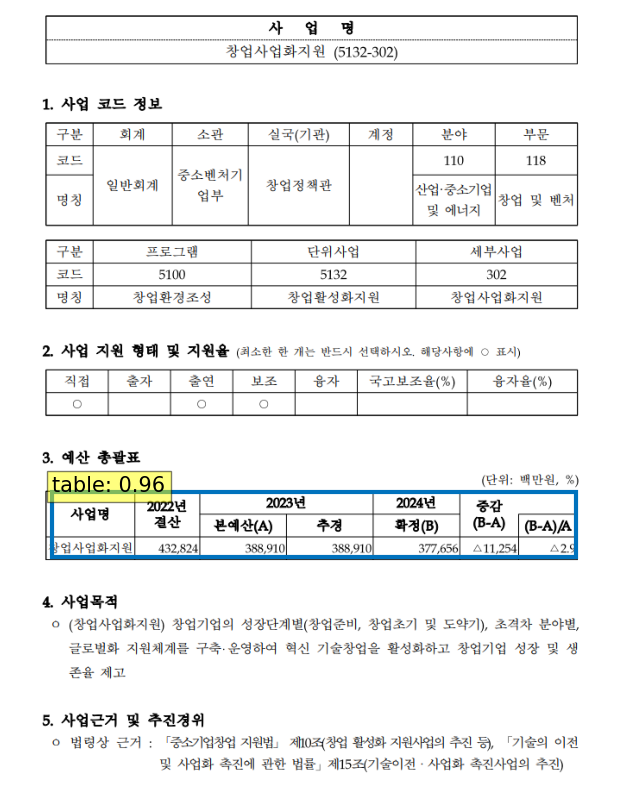

Iteration 2 - RAM Usage: 2131.90 MB, Time Usage: 4.80 seconds


In [ ]:
count = 0
root = "/kaggle/input/pubtables-img-detect-test/PubTables-1M-Detection_Images_Test"
files = ["/content/스크린샷 2024-08-01 173944.png"]


for _file in files:
    start_time = time.time()

    pred_bbox = table_detection(_file)


    count += 1

    end_time = time.time()
    time_usage = end_time - start_time
    ram_usage = psutil.Process(os.getpid()).memory_info().rss / 1024 / 1024

    print(f"Iteration {count + 1} - RAM Usage: {ram_usage:.2f} MB, Time Usage: {time_usage:.2f} seconds")

    if count > 2:
        break

In [ ]:
ram_usage = psutil.Process(os.getpid()).memory_info().rss / 1024 / 1024

print(f"ram usage : {ram_usage}")

ram usage : 2137.88671875


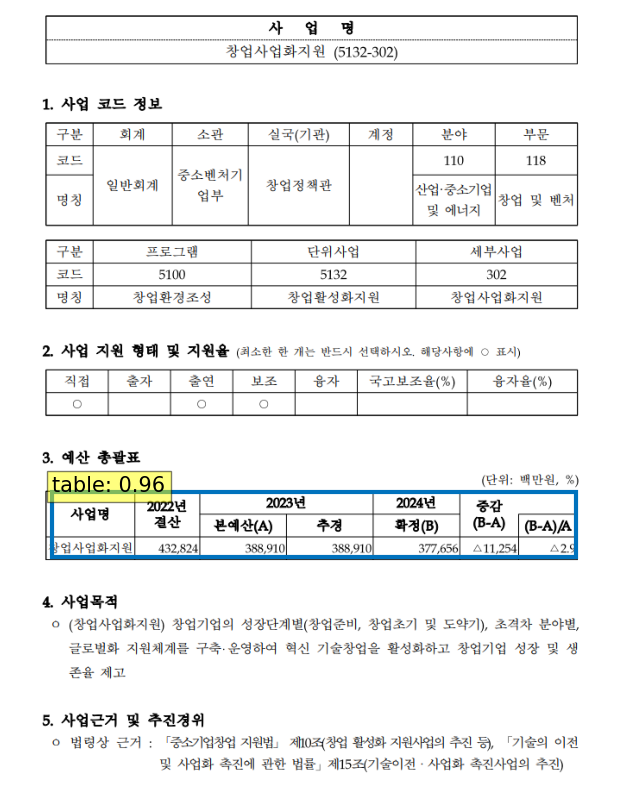

Iteration 2 - RAM Usage: 2156.90 MB, Time Usage: 4.04 seconds


In [ ]:
count = 0

for _file in files:
    start_time = time.time()

    cell_detection(_file)
    count+=1

    end_time = time.time()
    time_usage = end_time - start_time
    ram_usage = psutil.Process(os.getpid()).memory_info().rss / 1024 / 1024

    print(f"Iteration {count + 1} - RAM Usage: {ram_usage:.2f} MB, Time Usage: {time_usage:.2f} seconds")

    if(count>2):
        break


In [ ]:
def compute_boxes(image_path):
    image = Image.open(image_path).convert("RGB")
    width, height = image.size

    encoding = feature_extractor(image, return_tensors="pt")

    with torch.no_grad():
        outputs = model(**encoding)

    results = feature_extractor.post_process_object_detection(outputs, threshold=0.7, target_sizes=[(height, width)])[0]
    boxes = results['boxes'].tolist()
    labels = results['labels'].tolist()

    return boxes,labels

def extract_table(image_path):
    image = Image.open(image_path).convert("RGB")
    boxes,labels = compute_boxes(image_path)

    cell_locations = []

    for box_row, label_row in zip(boxes, labels):
        if label_row == 2:
            for box_col, label_col in zip(boxes, labels):
                if label_col == 1:
                    cell_box = (box_col[0], box_row[1], box_col[2], box_row[3])
                    cell_locations.append(cell_box)

    cell_locations.sort(key=lambda x: (x[1], x[0]))

    print(cell_locations)
    num_columns = 0
    box_old = cell_locations[0]

    for box in cell_locations[1:]:
        x1, y1, x2, y2 = box
        x1_old, y1_old, x2_old, y2_old = box_old
        num_columns += 1
        if y1 > y1_old:
            break

        box_old = box

    headers = []
    for box in cell_locations[:num_columns]:
        x1, y1, x2, y2 = box
        cell_image = image.crop((x1, y1, x2, y2))
        new_width = cell_image.width * 4
        new_height = cell_image.height * 4
        cell_image = cell_image.resize((new_width, new_height), resample=Image.LANCZOS)
        cell_text = pytesseract.image_to_string(cell_image)
        headers.append(cell_text.rstrip())

    df = pd.DataFrame(columns=headers)

    row = []
    for box in cell_locations[num_columns:]:
        x1, y1, x2, y2 = box
        cell_image = image.crop((x1, y1, x2, y2))
        new_width = cell_image.width * 4
        new_height = cell_image.height * 4
        cell_image = cell_image.resize((new_width, new_height), resample=Image.LANCZOS)
        cell_text = pytesseract.image_to_string(cell_image)

        if len(cell_text) > num_columns:
            cell_text = cell_text[:num_columns]

        row.append(cell_text.rstrip())

        if len(row) == num_columns:
            df.loc[len(df)] = row
            row = []

    return df

image_path = '/content/스크린샷 2024-08-01 174621.png'
df = extract_table(image_path)

[]


IndexError: list index out of range

In [ ]:
from transformers import DetrFeatureExtractor

file_path = '/content/스크린샷 2024-08-01 173944.png'
image = Image.open(file_path).convert("RGB")
width, height = image.size
image.resize((int(width*0.5), int(height*0.5)))

feature_extractor = DetrFeatureExtractor()
encoding = feature_extractor(image, return_tensors="pt")
encoding.keys()

dict_keys(['pixel_values', 'pixel_mask'])

In [ ]:
from transformers import TableTransformerForObjectDetection

model = TableTransformerForObjectDetection.from_pretrained("microsoft/table-transformer-detection")

Some weights of the model checkpoint at microsoft/table-transformer-detection were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
import torch

with torch.no_grad():
  outputs = model(**encoding)

In [ ]:
import matplotlib.pyplot as plt

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

def plot_results(pil_img, scores, labels, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for score, label, (xmin, ymin, xmax, ymax),c  in zip(scores.tolist(), labels.tolist(), boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        text = f'{model.config.id2label[label]}: {score:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [ ]:
# rescale bounding boxes
width, height = image.size
results = feature_extractor.post_process_object_detection(outputs, threshold=0.7, target_sizes=[(height, width)])[0]

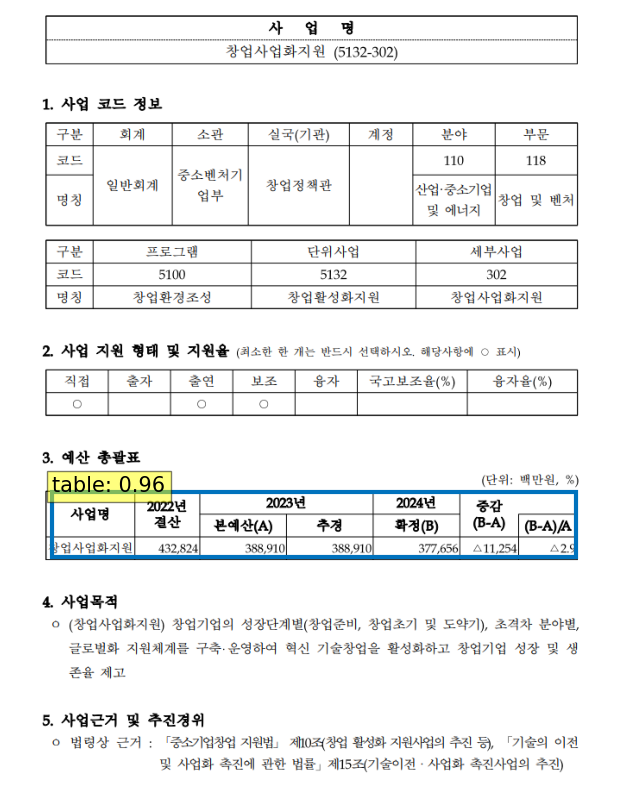

In [ ]:
plot_results(image, results['scores'], results['labels'], results['boxes'])

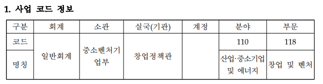

In [ ]:
from huggingface_hub import hf_hub_download
from PIL import Image

file_path = '/content/스크린샷 2024-08-01 174621.png'
image = Image.open(file_path).convert("RGB")
width, height = image.size
image.resize((int(width*0.5), int(height*0.5)))

In [ ]:
encoding = feature_extractor(image, return_tensors="pt")
encoding.keys()

dict_keys(['pixel_values', 'pixel_mask'])

In [ ]:

from transformers import TableTransformerForObjectDetection

model = TableTransformerForObjectDetection.from_pretrained("microsoft/table-transformer-structure-recognition")

Some weights of the model checkpoint at microsoft/table-transformer-structure-recognition were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
with torch.no_grad():
  outputs = model(**encoding)

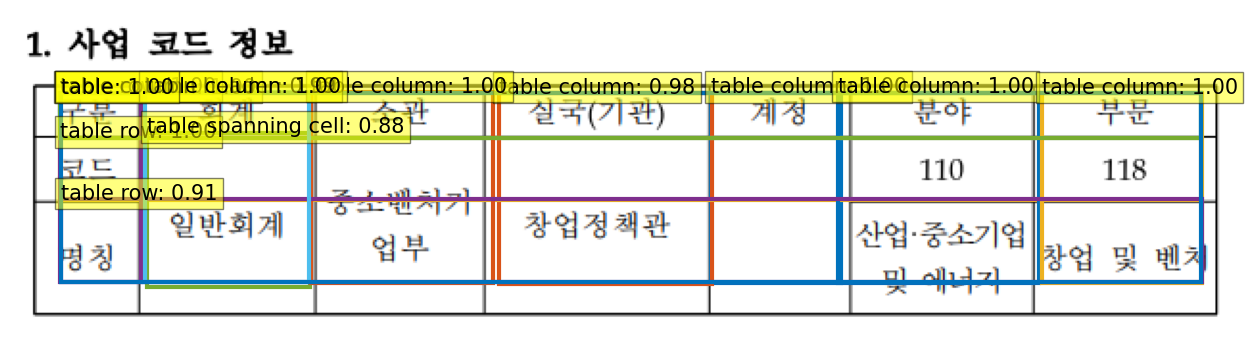

In [ ]:
target_sizes = [image.size[::-1]]
results = feature_extractor.post_process_object_detection(outputs, threshold=0.6, target_sizes=target_sizes)[0]
plot_results(image, results['scores'], results['labels'], results['boxes'])

In [ ]:
model.config.id2label

{0: 'table',
 1: 'table column',
 2: 'table row',
 3: 'table column header',
 4: 'table projected row header',
 5: 'table spanning cell'}

In [ ]:
def compute_boxes(image_path):
    image = Image.open(image_path).convert("RGB")
    width, height = image.size

    encoding = feature_extractor(image, return_tensors="pt")

    with torch.no_grad():
        outputs = model(**encoding)

    results = feature_extractor.post_process_object_detection(outputs, threshold=0.7, target_sizes=[(height, width)])[0]
    boxes = results['boxes'].tolist()
    labels = results['labels'].tolist()

    return boxes,labels

def extract_table(image_path):
    image = Image.open(image_path).convert("RGB")
    boxes,labels = compute_boxes(image_path)

    cell_locations = []

    for box_row, label_row in zip(boxes, labels):
        if label_row == 2:
            for box_col, label_col in zip(boxes, labels):
                if label_col == 1:
                    cell_box = (box_col[0], box_row[1], box_col[2], box_row[3])
                    cell_locations.append(cell_box)

    cell_locations.sort(key=lambda x: (x[1], x[0]))

    print(cell_locations)
    num_columns = 0
    box_old = cell_locations[0]

    for box in cell_locations[1:]:
        x1, y1, x2, y2 = box
        x1_old, y1_old, x2_old, y2_old = box_old
        num_columns += 1
        if y1 > y1_old:
            break

        box_old = box

    headers = []
    for box in cell_locations[:num_columns]:
        x1, y1, x2, y2 = box
        cell_image = image.crop((x1, y1, x2, y2))
        new_width = cell_image.width * 4
        new_height = cell_image.height * 4
        cell_image = cell_image.resize((new_width, new_height), resample=Image.LANCZOS)
        cell_text = pytesseract.image_to_string(cell_image)
        headers.append(cell_text.rstrip())

    df = pd.DataFrame(columns=headers)

    row = []
    for box in cell_locations[num_columns:]:
        x1, y1, x2, y2 = box
        cell_image = image.crop((x1, y1, x2, y2))
        new_width = cell_image.width * 4
        new_height = cell_image.height * 4
        cell_image = cell_image.resize((new_width, new_height), resample=Image.LANCZOS)
        cell_text = pytesseract.image_to_string(cell_image)

        if len(cell_text) > num_columns:
            cell_text = cell_text[:num_columns]

        row.append(cell_text.rstrip())

        if len(row) == num_columns:
            df.loc[len(df)] = row
            row = []

    return df

image_path = '/content/스크린샷 2024-08-01 174621.png'
df = extract_table(image_path)

[(25.432647705078125, 42.92229461669922, 67.9721450805664, 66.61544799804688), (69.75684356689453, 42.92229461669922, 155.36509704589844, 66.61544799804688), (156.53854370117188, 42.92229461669922, 251.0024871826172, 66.61544799804688), (254.2147674560547, 42.92229461669922, 365.4416809082031, 66.61544799804688), (364.4598388671875, 42.92229461669922, 432.26959228515625, 66.61544799804688), (430.7149963378906, 42.92229461669922, 535.7578125, 66.61544799804688), (536.9405517578125, 42.92229461669922, 620.340087890625, 66.61544799804688), (25.432647705078125, 66.38977813720703, 67.9721450805664, 98.65702819824219), (69.75684356689453, 66.38977813720703, 155.36509704589844, 98.65702819824219), (156.53854370117188, 66.38977813720703, 251.0024871826172, 98.65702819824219), (254.2147674560547, 66.38977813720703, 365.4416809082031, 98.65702819824219), (364.4598388671875, 66.38977813720703, 432.26959228515625, 98.65702819824219), (430.7149963378906, 66.38977813720703, 535.7578125, 98.657028198

In [ ]:
df

,,3| 7],eA\n<4,43 = (7) 2),Al 3,A,ie\nof
0,|r,,= » «wi,,,110,118
1,,Bw} AI],ss\n\naa,AY BAW,,jus ear,


# 3. Image-Text to Text

In [ ]:
# !pip install --upgrade transformers
# !pip install transformers >= 4.44.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 32.6 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.42.4
    Uninstalling transformers-4.42.4:
      Successfully uninstalled transformers-4.42.4


ERROR: Could not find a version that satisfies the requirement 4.44.0 (from versions: none)
ERROR: No matching distribution found for 4.44.0


In [ ]:
#
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
import transformers

print(transformers.__version__)

4.42.4


In [ ]:
images = ["/content/drive/MyDrive/Data/dacon/finance/processed/image/pymupdf4llm/2024년도 성과계획서(총괄편).pdf-15-0.png", "/content/drive/MyDrive/Data/dacon/finance/processed/image/pymupdf4llm/중소벤처기업부_창업사업화지원.pdf-1-0.png", "/content/drive/MyDrive/Data/dacon/finance/processed/image/pymupdf4llm/2024년도 성과계획서(총괄편).pdf-33-0.png"]

## 3.1 ViLT

In [ ]:
from transformers import ViltProcessor, ViltForImageAndTextRetrieval
from PIL import Image
import requests

# 모델과 프로세서 불러오기
processor = ViltProcessor.from_pretrained("dandelin/vilt-b32-mlm")
model = ViltForImageAndTextRetrieval.from_pretrained("dandelin/vilt-b32-mlm")

# 예제 이미지 불러오기
image = Image.open(images[0])

# 텍스트 입력
text = "아래 표 또는 도식도를 설명하시오."

# 입력 데이터 전처리
inputs = processor(text=text, images=image, return_tensors="pt")

# 모델 예측
outputs = model(**inputs)
logits = outputs.logits
idx = logits.argmax(-1).item()
print("Predicted answer:", model.config.id2label[idx])

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of ViltForImageAndTextRetrieval were not initialized from the model checkpoint at dandelin/vilt-b32-mlm and are newly initialized: ['rank_output.bias', 'rank_output.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Predicted answer: LABEL_0


## 3.2 Idefics3-8B(-Llama3)

In [ ]:
!pip install -q git+https://github.com/huggingface/transformers.git
!pip install -q accelerate datasets peft bitsandbytes

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 34.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.4/296.4 kB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.5/137.5 MB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 54.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 54.8 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=

In [ ]:
!pip uninstall -y pyarrow fsspec
!pip install pyarrow==14.0.1 fsspec==2024.6.1


Found existing installation: pyarrow 17.0.0
Uninstalling pyarrow-17.0.0:
  Successfully uninstalled pyarrow-17.0.0
Found existing installation: fsspec 2024.5.0
Uninstalling fsspec-2024.5.0:
  Successfully uninstalled fsspec-2024.5.0
  Using cached fsspec-2024.6.1-py3-none-any.whl.metadata (11 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.0/38.0 MB 58.7 MB/s eta 0:00:00
Using cached fsspec-2024.6.1-py3-none-any.whl (177 kB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 2.20.0 requires fsspec[http]<=2024.5.0,>=2023.1.0, but you have fsspec 2024.6.1 which is incompatible.
datasets 2.20.0 requires pyarrow>=15.0.0, but you have pyarrow 14.0.1 which is incompatible.


ERROR: Operation cancelled by user


In [ ]:
!pip install -q git+https://github.com/huggingface/transformers.git
!pip install -q accelerate datasets peft bitsandbytes

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
!pip install flash-attn>=2.1.0

Y


In [ ]:
import transformers

print(transformers.__version__)

4.45.0.dev0


In [ ]:
import requests
import torch
from PIL import Image
from io import BytesIO

from transformers import AutoProcessor, AutoModelForVision2Seq
from transformers.image_utils import load_image

DEVICE = "cuda:0"

# Note that passing the image urls (instead of the actual pil images) to the processor is also possible
image1 = load_image(images[0])
image2 = load_image(images[1])
image3 = load_image(images[2])

processor = AutoProcessor.from_pretrained("HuggingFaceM4/Idefics3-8B-Llama3")
model = AutoModelForVision2Seq.from_pretrained(
    "HuggingFaceM4/Idefics3-8B-Llama3",
).to(DEVICE)


# messages = [
#     {
#         "role": "user",
#         "content": [
#             {"type": "image"},
#             {"type": "text", "text": "이 이미지는 성과목표관리 체계도입니다. 이를 설명해주세요. 절대 그림 내부 단어를 바꾸지 마세요."},
#         ]
#     },
#     {
#         "role": "assistant",
#         "content": [
#             {"type": "text", "text": "이 이미지는 '성과목표관리 체계도'를 보여줍니다. 이를 통해 조직의 목표 달성과 관련된 전략적 구조를 설명하고 있습니다. 1. 임무:최상위 2. 비전: 임무 바로 하위. 전략목표를 하위로 두고 있습니다. 3. 전략목표:  I, II, III, IV 4개의 전략목표가 있으며 하위로 프로그램 목표가 있습니다. 4. 프로그램 목표: 최하위. 전략목표 II의 프로그램 목표 II-1, II-2, II-3 이 있으며 전략목표 IV의 프로그램 목표 IV-1이 있습니다."},
#         ]
#     },
#     {
#         "role": "user",
#         "content": [
#             {"type": "image"},
#             {"type": "text", "text": "이 이미지는 중소벤처기업부 창업사업화 지원의 '사업 집행절차' 도식도 입니다. 이를 설명해주세요. 절대 그림 내부 단어를 바꾸지 마세요."},
#         ]
#     },
# ]


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/520 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/51.7k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/951 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/7.23k [00:00<?, ?B/s]

ValueError: The checkpoint you are trying to load has model type `idefics3` but Transformers does not recognize this architecture. This could be because of an issue with the checkpoint, or because your version of Transformers is out of date.

In [ ]:
import requests
import torch
from PIL import Image
from io import BytesIO
# from peft import LoraConfig
from transformers import AutoProcessor, BitsAndBytesConfig, Idefics2ForConditionalGeneration
from transformers import AutoProcessor, AutoModelForVision2Seq
from transformers.image_utils import load_image


# Note that passing the image urls (instead of the actual pil images) to the processor is also possible


# model_id = "HuggingFaceM4/idefics2-8b"  #Idefics3-8B-Llama3
# processor = AutoProcessor.from_pretrained(model_id)
# model = AutoModelForVision2Seq.from_pretrained(model_id).to(DEVICE)


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
USE_LORA = False
USE_QLORA = False


processor = AutoProcessor.from_pretrained(
    "HuggingFaceM4/idefics2-8b",
    do_image_splitting=False
)


# Three options for training, from the lowest precision training to the highest precision training:
# - QLora
# - Standard Lora
# - Full fine-tuning
# if USE_QLORA or USE_LORA:
#     lora_config = LoraConfig(
#         r=8,
#         lora_alpha=8,
#         lora_dropout=0.1,
#         target_modules='.*(text_model|modality_projection|perceiver_resampler).*(down_proj|gate_proj|up_proj|k_proj|q_proj|v_proj|o_proj).*$',
#         use_dora=False if USE_QLORA else True,
#         init_lora_weights="gaussian"
#     )
#     if USE_QLORA:
#         bnb_config = BitsAndBytesConfig(
#             load_in_4bit=True,
#             bnb_4bit_quant_type="nf4",
#             bnb_4bit_compute_dtype=torch.float16
#         )
#     model = Idefics2ForConditionalGeneration.from_pretrained(
#         "HuggingFaceM4/idefics2-8b",
#         torch_dtype=torch.float16,
#         quantization_config=bnb_config if USE_QLORA else None,
#     )
#     model.add_adapter(lora_config)
#     model.enable_adapters()
# else:
model = Idefics2ForConditionalGeneration.from_pretrained(
    "HuggingFaceM4/idefics2-8b",
    torch_dtype=torch.float16,
    _attn_implementation="flash_attention_2", # Only available on A100 or H100
).to(DEVICE)

# no train
model.eval()

Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

Idefics2ForConditionalGeneration(
  (model): Idefics2Model(
    (vision_model): Idefics2VisionTransformer(
      (embeddings): Idefics2VisionEmbeddings(
        (patch_embedding): Conv2d(3, 1152, kernel_size=(14, 14), stride=(14, 14), padding=valid)
        (position_embedding): Embedding(4900, 1152)
      )
      (encoder): Idefics2Encoder(
        (layers): ModuleList(
          (0-26): 27 x Idefics2EncoderLayer(
            (self_attn): Idefics2VisionFlashAttention2(
              (k_proj): Linear(in_features=1152, out_features=1152, bias=True)
              (v_proj): Linear(in_features=1152, out_features=1152, bias=True)
              (q_proj): Linear(in_features=1152, out_features=1152, bias=True)
              (out_proj): Linear(in_features=1152, out_features=1152, bias=True)
            )
            (layer_norm1): LayerNorm((1152,), eps=1e-06, elementwise_affine=True)
            (mlp): Idefics2VisionMLP(
              (activation_fn): PytorchGELUTanh()
              (fc1): Lin

In [ ]:
image1 = load_image(images[0])
image2 = load_image(images[1])
image3 = load_image(images[2])


# Create inputs
messages = [
    {
        "role": "user",
        "content": [
            {"type": "image"},
            {"type": "text", "text": "이 이미지는 성과목표관리 체계도입니다. 이를 설명해주세요. 절대 그림 내부 단어를 바꾸지 마세요."},
        ]
    }
]



prompt = processor.apply_chat_template(messages, add_generation_prompt=True)
inputs = processor(text=[prompt.strip()], images=[image1], return_tensors="pt", padding=True).to(DEVICE)
generated_ids = model.generate(**inputs, max_new_tokens=512)
generated_texts = processor.batch_decode(generated_ids[:, inputs["input_ids"].size(1):], skip_special_tokens=True)

print(generated_texts)

NameError: name '_flash_attention_forward' is not defined

In [ ]:
# 결과....ㅎㅎ
# User: 한국어로 상세히 설명하세요. 그림 내부 단어를 그대로 사용하세요. 이 이미지는 성과목표관리 체계도입니다. 구조도 상위부터 설명하세요
# Assistant: 1. 성과목표관리 체계
# 2. 성과목표관리 체계
# 3. 성과목표관리 체계
# 4. 성과목표관리 체계
# 5. 성과목표관리 체계
# 6. 성과목표관리 체계
# 7. 성과목표관리 체계
# 8. 성과목표관리 체계
# 9. 성과목표관리 체계
# 10. 성과목표관리 체계
# 11. 성과목표관리 체계
# 12. 성과목표관리 체계
# 13. 성과목표관리 체계
# 14. 성과목표관리 체계
# 15. 성과목표관리 체계
# 16. 성과목표관리 체계
# 17. 성과목표관리 체계
# 18. 성과목표관리 체계
# 19. 성과목표관리 체계
# 20. 성과목표관리 체계
# 21. 성과목표관리 체계
# 22. 성과목표관리 체계
# 23. 성과목표관리 체계
# 24. 성과목표관리 체계
# 25. 성과목표관리 체계
# 26. 성과목표관리 체계
# 27. 성과목표관리 체계
# 28. 성과목표관리 체계
# 29. 성과목표관리 체계
# 30. 성과목표관리 체계
# 31. 성과목표관리 체계
# 32. 성과목표관리 체계
# 33. 성과목표관리 체계
# 34. 성과목표관리 체계
# 35. 성과목표관리 체계
# 36. 성과목표관리 체계
# 37. 성과목표관리 체계
# 38

## 3.3 llama vision

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from PIL import Image
import requests
from io import BytesIO

image = Image.open(images[0])

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModelForCausalLM.from_pretrained(
    "qresearch/llama-3.1-8B-vision-378",
    trust_remote_code=True,
    torch_dtype=torch.float16,
).to(DEVICE)

tokenizer = AutoTokenizer.from_pretrained("qresearch/llama-3.1-8B-vision-378", use_fast=True,)



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

이 이미지는 성과목표관리 체계도입니다. 체계도는 성과목표를 달성하기 위해 필요한 단계와 과정을 보여주는 도표입니다.

이 체계도는 다음과 같은 단계를 포함합니다.

1. 목표 설정: 목표를 설정하고, 달성하기 위해 필요한 작업과 시간을 결정합니다.
2. 업무 배분: 업무를 배분하고, 각 팀원에게 업무를 할당합니다.
3. 진행 상황 확인: 진행 상황을 확인하고, 업무의 진행 상황을 모니터링합니다.
4. 성과


In [ ]:
image = Image.open(images[1])

print(images[1])

print(
    model.answer_question(
        image, "이 이미지는 중소벤처기업부 창업사업화 지원의 '사업 집행절차' 도식도 입니다. 화살표 순서대로 설명하되, 절대 그림 내부 단어를 변경하지 마시오.", tokenizer, max_new_tokens=512, do_sample=True, temperature=0.3
    ),
)

/content/drive/MyDrive/Data/dacon/finance/processed/image/pymupdf4llm/중소벤처기업부_창업사업화지원.pdf-1-0.png
이 이미지는 중소벤처기업부 창업사업화 지원의 '사업 집행절차' 도식입니다. 화살표 순서대로 설명하겠습니다.

1. **사업 계획**: 사업을 수행하기 위해 필요한 계획을 수립합니다.
2. **사업 승인**: 사업 계획을 검토하고 승인합니다.
3. **사업 집행**: 승인된 사업 계획을 실제로 수행합니다.
4. **사업 평가**: 사업을 수행한 후 평가합니다.
5. **사업 결과**: 사업 평가 결과를 확인하고, 사업의 성공 여부를 판단합니다.

이 도식은 중소벤처기업부 창업사업화 지원의 사업 집행절차를 보여주고 있습니다.


## 3.4 Cephalo-Phi-3-vision-128k-4b-alpha

In [ ]:
from PIL import Image
import requests
from transformers import AutoModelForCausalLM
from transformers import AutoProcessor

model_id = "lamm-mit/Cephalo-Phi-3-vision-128k-4b-alpha"
model = AutoModelForCausalLM.from_pretrained(model_id, device_map="cuda", trust_remote_code=True, torch_dtype="auto")
processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)

messages = [
    {"role": "user", "content": "<|image_1|>\n이 이미지는 성과목표관리 체계도입니다. 이를 한국어로 설명해주세요."},
    ]



image = Image.open(images[0])

prompt = processor.tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

inputs = processor(prompt, [image], return_tensors="pt").to("cuda:0")

generation_args = {
                    "max_new_tokens": 512,
                    "temperature": 0.1,
                    "do_sample": True,
                    "stop_strings": ['<|end|>',
                                     '<|endoftext|>'],
                    "tokenizer": processor.tokenizer,
                  }

generate_ids = model.generate(**inputs, eos_token_id=processor.tokenizer.eos_token_id, **generation_args)

# remove input tokens
generate_ids = generate_ids[:, inputs['input_ids'].shape[1]:]
response = processor.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]

print(response)

config.json:   0%|          | 0.00/3.77k [00:00<?, ?B/s]

configuration_phi3_v.py:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Phi-3-vision-128k-instruct:
- configuration_phi3_v.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_phi3_v.py:   0%|          | 0.00/75.4k [00:00<?, ?B/s]

image_embedding_phi3_v.py:   0%|          | 0.00/14.1k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Phi-3-vision-128k-instruct:
- image_embedding_phi3_v.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/microsoft/Phi-3-vision-128k-instruct:
- modeling_phi3_v.py
- image_embedding_phi3_v.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


pytorch_model.bin.index.json:   0%|          | 0.00/69.0k [00:00<?, ?B/s]

pytorch_model-00001-of-00002.bin:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

pytorch_model-00002-of-00002.bin:   0%|          | 0.00/3.35G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/525 [00:00<?, ?B/s]

processing_phi3_v.py:   0%|          | 0.00/11.3k [00:00<?, ?B/s]

image_processing_phi3_v.py:   0%|          | 0.00/11.4k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Phi-3-vision-128k-instruct:
- image_processing_phi3_v.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/microsoft/Phi-3-vision-128k-instruct:
- processing_phi3_v.py
- image_processing_phi3_v.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
/usr/local/lib/python3.10/dist-packages/transformers/models/auto/image_processing_auto.py:510: FutureWarning: The image_processor_class argument is deprecated and will be removed in v4.42. Please use `slow_image_processor_class`, or `fast_image_processor_class` instead
  if image_processor_class is not None:


tokenizer_config.json:   0%|          | 0.00/9.44k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.85M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/670 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
The `seen_tokens` attribute is deprecated and will be removed in v4.41. Use the `cache_position` model input instead.
/root/.cache/huggingface/modules/transformers_modules/microsoft/Phi-3-vision-128k-instruct/6065b7a1a412feff7ac023149f65358b71334984/image_embedding_phi3_v.py:197: UserWarning: Phi-3-V modifies `input_ids` in-place and the tokens indicating images will be removed after model forward. If your workflow requires multiple forward passes on the same `input_ids`, please make a copy of `input_ids` before passing it to the model.
  warnings.warn(


이 이미지는 성과목표관리 체계를 포함한 체계를 표현합니다. 이 체계에서 성과목표를 처리하기 위해 발생한 사항들을 표시합니다.

1. 성과목표 체계의 구성요소:
   - 성과목표 체계의 기본 구성요소는 성과목표를 처리하기 위한 기본 기본 기본 기본 기본 기본 기본 기본 기본 기본 기본 기본 기본 기본 기본 기본 기본 기본 기본 기본 기본 기본 기본 기본 기본 기본 기본 기본 기본 기본 기본 기본 기본 기본 기본 기본 기본 기본 기본 기본 기  기본 기본 기본 기본 기본 기본 기본 기본 기본 기본 기본 기본 기본 기본 기본 기본 기본 기본 기  기본 기본 기본 기본 기본 기�


# 4. Text Spliter

## 4.1 RecursiveCharactorSplitter

## 4.2 Token Splitter

## 4.3 SemanticChunker

In [ ]:

from langchain_experimental.text_splitter import SemanticChunker
from langchain.embeddings import HuggingFaceEmbeddings
from langchain_text_splitters import KonlpyTextSplitter

embeddings = HuggingFaceEmbeddings(
    model_name="jhgan/ko-sroberta-multitask",
    encode_kwargs={'normalize_embeddings': False},
    model_kwargs={'device': 'cpu'},
)
text_splitter = SemanticChunker(embeddings,
                                breakpoint_threshold_type="percentile", # percentile, interquartile,
                                breakpoint_threshold_amount=50,) # 70, 0.5

text_splitter = KonlpyTextSplitter(
    separator='\n\n',
) # X

# RecursiveCharacterTextSplitter 가 가장 나았음


# 5. pdf layout

## 5.1 layout parser

In [ ]:
!pip3 install -U layoutparser
!pip3 install 'git+https://github.com/facebookresearch/detectron2.git@v0.4#egg=detectron2'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 1.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.5/48.5 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.2/19.2 MB 69.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 60.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 53.0 MB/s eta 0:00:00
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31531 sha256=42b6fadbff44362c97af816cd2ec98762804b92bae93f37a82ce2c72f72b5ba1
  Stored in directory: /root/.cache/pip/wheels/9a/a3/b6/ac0fcd1b4ed5cfeb3db92e6a0e476cfd48ed0df92b91080c1d
Successfully built iopath
  Cloning https://github.com/facebookresearch/detectron2.git (to revision v0.4) to /tmp/pip-install-pja4b22o/detectron2_9b9c

In [ ]:
!pip install PyMuPDF

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 52.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 84.3 MB/s eta 0:00:00


In [1]:
import layoutparser as lp
import cv2

model = lp.Detectron2LayoutModel('lp://PubLayNet/mask_rcnn_X_101_32x8d_FPN_3x/config',
                                 extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.7],
                                 label_map={0: "Text", 1: "Title", 2: "List", 3:"Table", 4:"Figure"})

/home/bjh/anaconda3/envs/pymupdf/lib/python3.10/site-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_locatio

In [17]:
import pymupdf as fitz
import numpy as np

doc_path = '/home/bjh/dacon/pdf/dacon/train_source/1-1 2024 주요 재정통계 1권.pdf'
doc = fitz.Document(doc_path)
page = doc.load_page(31)
matrix = fitz.Matrix(*[4, 4])                              # 해상도 높이기
pix = page.get_pixmap(clip=page.rect, matrix=matrix)            # pixmap 변환
image_np = np.frombuffer(pix.samples, dtype=np.uint8)      # ndarray 변환
image_np = image_np.reshape(pix.height, pix.width, pix.n)  # reshape


layout = model.detect(image_np).to_dict()
layout

{'page_data': {},
 'blocks': [{'x_1': 315.9671630859375,
   'y_1': 629.5438232421875,
   'x_2': 1958.4591064453125,
   'y_2': 2556.009521484375,
   'block_type': 'rectangle',
   'type': 'Table',
   'score': 0.997628390789032},
  {'x_1': 314.11968994140625,
   'y_1': 2582.978271484375,
   'x_2': 1013.5001831054688,
   'y_2': 2660.395263671875,
   'block_type': 'rectangle',
   'type': 'Text',
   'score': 0.9653106927871704},
  {'x_1': 659.528564453125,
   'y_1': 343.9122619628906,
   'x_2': 1941.612060546875,
   'y_2': 395.5721130371094,
   'block_type': 'rectangle',
   'type': 'Text',
   'score': 0.8513739705085754},
  {'x_1': 687.0950317382812,
   'y_1': 407.8601989746094,
   'x_2': 1939.2935791015625,
   'y_2': 523.1842651367188,
   'block_type': 'rectangle',
   'type': 'List',
   'score': 0.7306644320487976}]}

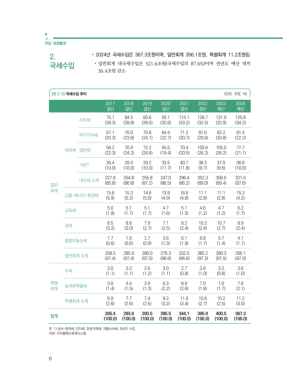

In [18]:
import matplotlib.pyplot as plt

plt.imshow(image_np)
plt.axis('off')  # 축 숨기기
plt.show()

In [ ]:

# model2 = lp.Detectron2LayoutModel('lp://TableBank/faster_rcnn_R_101_FPN_3x/config',
#                                  extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.8],
#                                  label_map={0: "Table"})

config.yaml?dl=1: 8.19kB [00:01, 7.77kB/s]
model_final.pth?dl=1: 482MB [00:05, 93.6MB/s]                          
